In [135]:
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [136]:
path = Path("/home/eimer/Dokumente/git/meta-gym/src/results/brax/std_0.1/CARLAnt")

In [68]:
path = Path("/home/eimer/Dokumente/git/meta-gym/src/results/classic_control/pbt_hps_hidden/p7/std_0.1/CARLPendulumEnv")

In [137]:
progress_fname = "progress.csv"
eval_fname = "evaluations.npz"
# context_dirs = [Path(x[0]) for x in os.walk(path)]
context_dirs = [path / Path(p) for p in os.listdir(path)]
cf_names = [p.stem for p in context_dirs]

dirs_per_cf = {}
for i, cf_name in enumerate(cf_names):
    cf_dir = context_dirs[i]
    agent_seed_dirs = os.listdir(cf_dir)
    agent_seed_dirs = [os.path.join(cf_dir, p) for p in agent_seed_dirs]
    dirs_per_cf[cf_name] = agent_seed_dirs

In [138]:
data = {}
evals = {}
for cf_name, cf_dirs in dirs_per_cf.items():
    D = []
    es = []
    for cf_dir in cf_dirs:
        cf_dir = Path(cf_dir)
        folder = cf_dir.stem
        agent, seed = folder.split("_")
        seed = int(seed)

        progress_fn = cf_dir / progress_fname
        eval_fn = cf_dir / eval_fname
        try:
            df = pd.read_csv(progress_fn)
        except:
            print(progress_fn)
        #evaluation = np.load(eval_fn)
        #es.append(evaluation)
        n = len(df['time/total_timesteps'])
        D.append(pd.DataFrame({
            "seed": [seed] * (n+1),
            "step": np.concatenate(([0], df['time/total_timesteps'].to_numpy())),
            #"episodes": df['time/episodes'].to_numpy(),
            "ep_rew_mean": np.concatenate(([0], df['rollout/ep_rew_mean'].to_numpy())),
        }))
    D = pd.concat(D)
    data[cf_name] = D
    #evals[cf_name] = es

In [71]:
evals['p7'] = evals['g']
data['p7'] = data['g']

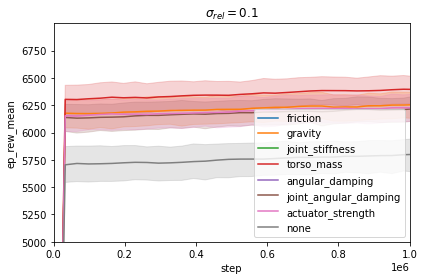

In [140]:
fig = plt.figure()
ax = fig.add_subplot(111)
for cf_name, df in data.items():
    ax = sns.lineplot(data=df, x="step", y="ep_rew_mean", ax=ax, label=cf_name)
title = r'$\sigma_{rel} = 0.1$'
ax.set_title(title)
#ax.legend()
ax.set_xlim(0, 1e6)
ax.set_ylim((5000, 6999))
fig.set_tight_layout(True)
plt.show()

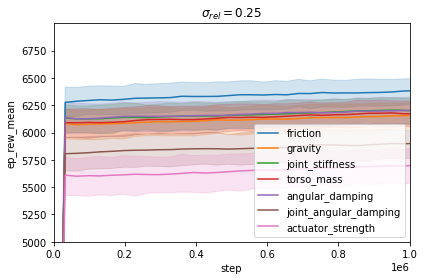

In [130]:
fig = plt.figure()
ax = fig.add_subplot(111)
for cf_name, df in data.items():
    if not cf_name == "none":
        ax = sns.lineplot(data=df, x="step", y="ep_rew_mean", ax=ax, label=cf_name)
title = r'$\sigma_{rel} = 0.25$'
ax.set_title(title)
#ax.legend()
ax.set_xlim(0, 1e6)
ax.set_ylim((5000, 6999))
fig.set_tight_layout(True)
plt.show()

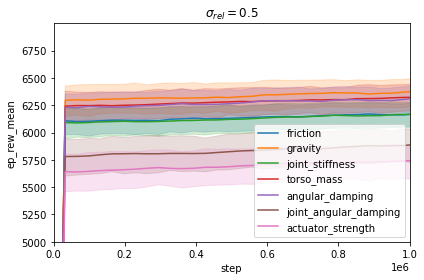

In [134]:
fig = plt.figure()
ax = fig.add_subplot(111)
for cf_name, df in data.items():
    if not cf_name == "none":
        ax = sns.lineplot(data=df, x="step", y="ep_rew_mean", ax=ax, label=cf_name)
title = r'$\sigma_{rel} = 0.5$'
ax.set_title(title)
#ax.legend()
ax.set_xlim(0, 1e6)
ax.set_ylim((5000, 6999))
fig.set_tight_layout(True)
plt.show()

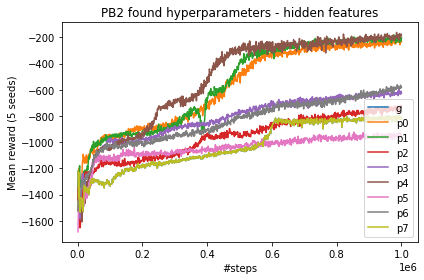

In [72]:
fig = plt.figure()
ax = fig.add_subplot(111)
for cf_name, df in data.items():
    ax = sns.lineplot(x=evals[cf_name][0]["timesteps"], y=np.mean(evals[cf_name][0]["results"], axis=1), ax=ax, label=cf_name)
title = f"PB2 found hyperparameters - hidden features"
ax.set_title(title)
ax.set_xlabel("#steps")
ax.set_ylabel("Mean reward (5 seeds)")
#ax.legend()
#ax.set_ylim(-200, 0)
#ax.set_xlim((0, 300))
fig.set_tight_layout(True)
plt.show()

In [117]:
del evals['g']
del data['g']

In [50]:
data_visible = data.copy()
evals_visible = evals.copy()

In [16]:
best_visible = "/home/eimer/Dokumente/git/meta-gym/src/results/classic_control/pbt_hps/p7/std_0.1/CARLPendulumEnv/g"
best_hidden = "/home/eimer/Dokumente/git/meta-gym/src/results/classic_control/pbt_hps_hidden/p4/std_0.1/CARLPendulumEnv/g"

In [38]:
import sys
sys.path.append("/home/eimer/Dokumente/git/meta-gym")
from src.context.sampling import sample_contexts

def get_context_around(mean):
    num_contexts = 100
    contexts = sample_contexts(
        "CARLPendulumEnv",
        f"g gmean {mean}",
        num_contexts,
        default_sample_std_percentage=0.1
    )

In [39]:
from src.envs import CARLPendulumEnv
from stable_baselines3 import DDPG
from functools import partial
from stable_baselines3.common.env_util import make_vec_env
import os

def eval_hidden(context):
    total_hidden = 0
    for i in range(5):
        EnvCls = partial(
            CARLPendulumEnv,
            contexts=context,
            logger=None,
            hide_context=True,
        )
        env = make_vec_env(EnvCls, n_envs=1)
        checkpoint_dir = best_hidden + f"/DDPG_{i}"
        checkpoint = os.path.join(checkpoint_dir, "model")
        model = DDPG.load(checkpoint, env=env)
    
        rewards = 0
        for j in range(10):
            state = env.reset()
            done = False
            while not done:
                action = model.predict(state)
                next_state, reward, done, _ = env.step(action[0])
                rewards += reward
                state = next_state
        rewards = rewards / 10
        total_hidden += rewards
    total_hidden = total_hidden / 5
    return total_hidden

In [40]:
def eval_visible(context):
    total_visible = 0
    for i in range(5):
        EnvCls = partial(
            CARLPendulumEnv,
            contexts=contexts,
            logger=None,
            hide_context=False,
        )
        env = make_vec_env(EnvCls, n_envs=1)
        checkpoint_dir = best_visible + f"/DDPG_{i}"
        checkpoint = os.path.join(checkpoint_dir, "model")
        model = DDPG.load(checkpoint, env=env)
    
        rewards = 0
        for j in range(10):
            state = env.reset()
            done = False
            while not done:
                action = model.predict(state)
                next_state, reward, done, _ = env.step(action[0])
                rewards += reward
                state = next_state
        rewards = rewards / 10
        total_visible += rewards
    total_visible = total_visible / 5
    return total_visible

In [45]:
performance_hidden = []
performance_visible = []
for g in [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22]:
    c = get_context_around(g)
    hidden = eval_hidden(c)
    visible = eval_visible(c)
    performance_hidden.append(hidden)
    performance_visible.append(visible)

/home/eimer/anaconda3/tmp/envs/meta-gym/lib/python3.9/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


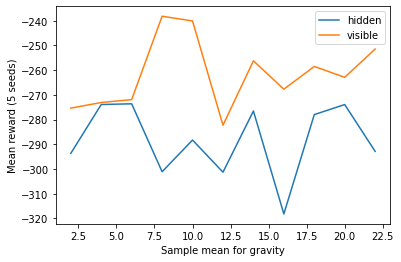

In [49]:
plt.plot([2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22], performance_hidden, label="hidden")
plt.plot([2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22], performance_visible, label="visible")
plt.legend()
plt.ylabel("Mean reward (5 seeds)")
plt.xlabel("Sample mean for gravity")
plt.show()